## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cat ml-1m/README

--2025-03-02 12:56:46--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Распознаётся files.grouplens.org (files.grouplens.org)… 128.101.65.152
Подключение к files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 5917549 (5,6M) [application/zip]
Сохранение в: «ml-1m.zip»

ml-1m.zip           100%[===================>]   5,64M  1,71MB/s    за 3,3s    

2025-03-02 12:56:50 (1,71 MB/s) - «ml-1m.zip» сохранён [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its 

In [2]:
import pandas as pd
import numpy as np
from typing import Union

In [3]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [5]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [6]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [7]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [8]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [9]:
df_train['user_id'].nunique(), df_train['user_id'].max()
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, 3009)

##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [17]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:
    result = np.zeros((df['user_id'].nunique(), df['item_id'].nunique()))
    result[df['user_id'], df['item_id']] = df['rating']
    return result #shape ~ [n_users, n_items]

In [18]:
interactions = df_to_matrix(df_train)

In [37]:
from scipy.sparse import coo_array

def df_to_coo(df: pd.DataFrame) -> coo_array:

    result = coo_array((df['rating'], (df['user_id'], df['item_id'])), 
                       shape=(df['user_id'].nunique(), df['item_id'].nunique()), dtype=np.float64).tocsr()

    return result # coo_array

In [38]:
coo_interactions = df_to_coo(df_train)

In [39]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [28]:
from scipy.sparse.linalg import svds

def make_svd(interactions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    # функция должна работать и для полной матрицы и для sparse матрицы(вам поможет isinstance).
    # если n_singular_values = -1, то берем все сингулярные числа для полной матрицы
    # и все кроме одного сингулярного числа для coo-матрицы(иначе scipy.sparse.linalg.svds не будет работать)


    if isinstance(interactions, np.ndarray):
        U, s, V = np.linalg.svd(interactions, full_matrices=False)
        if n_singular_values != -1:
            U = U[:, :n_singular_values]
            s = s[:n_singular_values]
            V = V[:n_singular_values, :]
    else:
        if n_singular_values == -1:
            n_singular_values = min(interactions.shape) - 1
        U, s, V = svds(interactions, n_singular_values)
    
    return U, np.diag(s), V

In [29]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [40]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [306]:
def make_svd_recommendations(interactions: Union[np.ndarray, coo_array], n_singular_values: int = -1, top_k: int = 100):
    # Возвращает матрицу вида n_users, top_k, то есть для каждого пользователя возвращаем индексы 
    # top_k самых релевантный айтемов среди тех с которыми он еще не взаимодействовал

    U, S, V = make_svd(interactions, n_singular_values)
    preds_matrix = U @ S @ V

    mask = np.zeros(interactions.shape)
    if isinstance(interactions, np.ndarray):
        mask[interactions == 0] = 1
    else:
        mask[interactions.toarray() == 0] = 1

    preds_matrix *= mask

    recommendations = np.flip(preds_matrix.argsort(axis=1), 1)

    return recommendations[:, :top_k] #shape ~ [n_users, top_k]

In [105]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [101]:
import time
from matplotlib import pyplot as plt

def ndcg_metric(gt_items, predicted):
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)

    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores):
    return np.sum(
        np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64
    )

def evaluate_recommender(df, model_preds, gt_col="test_interactions", topn=10):
    metric_values = []

    for idx, row in df.iterrows():
        gt_items = row[gt_col]
        metric_values.append(ndcg_metric(gt_items, row[model_preds]))

    return {"ndcg": np.mean([x for x in metric_values])}


def plot_graphs(interactions: Union[np.ndarray, coo_array], top_k: int = 100):
    df_interactions = df_test.groupby('user_id').apply(lambda x: [t for t in x.item_id]).reset_index().rename({0:'test_interactions'}, axis=1) 
    ndcg_s = []
    times = []
    for n_singular_values in [1, 10, 50, 200, 1000]:
        start = time.time()
        recs = make_svd_recommendations(interactions, n_singular_values, top_k)
        times.append(time.time() - start)
        df_interactions['SVD_preds'] = recs[df_interactions['user_id'], :].tolist()
        metric_results = evaluate_recommender(df_interactions, 'SVD_preds')
        ndcg_s.append(metric_results["ndcg"])
    plt.plot([1, 10, 50, 200, 1000], ndcg_s)
    plt.xlabel("n_singular_values")
    plt.ylabel("ndcg value")
    plt.show()

    plt.plot([1, 10, 50, 200, 1000], times)
    plt.xlabel("n_singular_values")
    plt.ylabel("time (seconds) to get recommendations")
    plt.show()

In [98]:
len(recs.tolist())

5365

/var/folders/5q/dr1_wwq51175s4qj4dnxgsz80000gn/T/ipykernel_41611/1013036364.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_interactions = df_test.groupby('user_id').apply(lambda x: [t for t in x.item_id]).reset_index().rename({0:'test_interactions'}, axis=1)


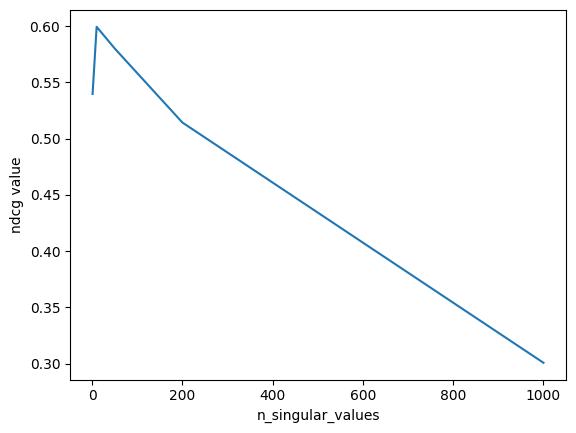

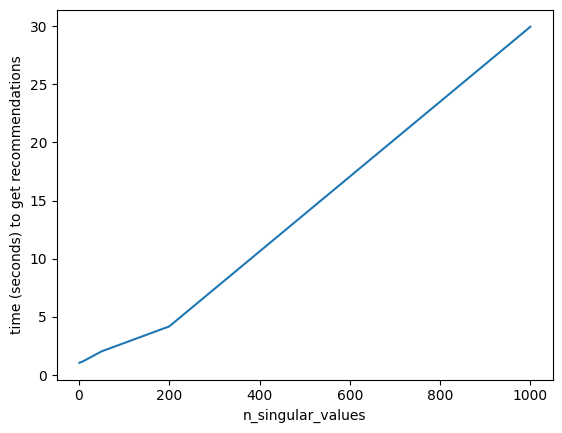

In [102]:
plot_graphs(coo_interactions)

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [108]:
df_interactions = df_test.groupby('user_id').apply(lambda x: [t for t in x.item_id]).reset_index().rename({0:'test_interactions'}, axis=1)

/var/folders/5q/dr1_wwq51175s4qj4dnxgsz80000gn/T/ipykernel_41611/483112249.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_interactions = df_test.groupby('user_id').apply(lambda x: [t for t in x.item_id]).reset_index().rename({0:'test_interactions'}, axis=1)


In [112]:
from implicit.cpu.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix

def make_als_recommendations(
    interactions: Union[np.ndarray, coo_array], 
    top_k: int = 100, 
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
):
    interactions = csr_matrix(interactions)
    als = AlternatingLeastSquares(factors=n_factors, regularization=regularization, alpha=alpha)
    als.fit(interactions)
    recommendations, _ = als.recommend(df_interactions['user_id'], interactions[df_interactions['user_id']], N=top_k)

    return recommendations #shape ~ [n_users, top_k]

In [118]:
recs = make_als_recommendations(interactions)
assert recs.shape == (df_test['user_id'].nunique(), 100)

  0%|          | 0/15 [00:00<?, ?it/s]

In [120]:
df_interactions['ALS_preds'] = recs.tolist()

In [122]:
evaluate_recommender(df_interactions, "ALS_preds")

{'ndcg': 0.5588585154314413}

In [123]:
recs_svd = make_svd_recommendations(coo_interactions, 10, 100)
df_interactions['SVD_preds'] = recs_svd[df_interactions['user_id'], :].tolist()

In [125]:
evaluate_recommender(df_interactions, "SVD_preds")

{'ndcg': 0.5993511113914561}

На графике для SVD мы видели, что наибольшее значение на метрике NDCG было при n_singular_values = 10, поэтому для сравнения я взял предсказания с ним. Как можно видеть, SVD при таких параметрах показало чуть лучший результат. Попробуем перебрать гиперпараметры для ALS

In [133]:
def objective(study, model="als"):
    n_factors = study.suggest_int('n_factors', 50, 500, step=50)
    alpha = study.suggest_float('alpha', 0.5, 5.0, step=0.5)
    regularization = study.suggest_float('regularization', 0.001, 0.1, step=0.01)

    als = AlternatingLeastSquares(factors=n_factors, regularization=regularization, alpha=alpha)
    als.fit(csr_matrix(interactions))
    recommendations, _ = als.recommend(df_interactions['user_id'], csr_matrix(interactions)[df_interactions['user_id']], N=100)

    df_interactions["ALS_hyperchecking"] = recommendations.tolist()
    return evaluate_recommender(df_interactions, "ALS_hyperchecking")['ndcg']

In [134]:
import optuna

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2025-03-02 20:01:24,963] A new study created in memory with name: no-name-54815fba-85c7-49c2-aae3-4a47d69b1eaa


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:02:13,700] Trial 0 finished with value: 0.48542356205623916 and parameters: {'n_factors': 350, 'alpha': 2.0, 'regularization': 0.051000000000000004}. Best is trial 0 with value: 0.48542356205623916.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:02:58,125] Trial 1 finished with value: 0.4883841289427574 and parameters: {'n_factors': 350, 'alpha': 4.5, 'regularization': 0.061}. Best is trial 1 with value: 0.4883841289427574.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:03:14,766] Trial 2 finished with value: 0.5558969424426493 and parameters: {'n_factors': 100, 'alpha': 2.5, 'regularization': 0.07100000000000001}. Best is trial 2 with value: 0.5558969424426493.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:03:57,817] Trial 3 finished with value: 0.4784436676165253 and parameters: {'n_factors': 350, 'alpha': 0.5, 'regularization': 0.021}. Best is trial 2 with value: 0.5558969424426493.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:04:11,254] Trial 4 finished with value: 0.5635827090714818 and parameters: {'n_factors': 50, 'alpha': 4.0, 'regularization': 0.041}. Best is trial 4 with value: 0.5635827090714818.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:04:47,167] Trial 5 finished with value: 0.5011591806413019 and parameters: {'n_factors': 250, 'alpha': 1.0, 'regularization': 0.021}. Best is trial 4 with value: 0.5635827090714818.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:05:18,106] Trial 6 finished with value: 0.5191978058342848 and parameters: {'n_factors': 200, 'alpha': 4.5, 'regularization': 0.031}. Best is trial 4 with value: 0.5635827090714818.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:05:35,234] Trial 7 finished with value: 0.5420969322293749 and parameters: {'n_factors': 100, 'alpha': 5.0, 'regularization': 0.001}. Best is trial 4 with value: 0.5635827090714818.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:05:51,851] Trial 8 finished with value: 0.5607597875706923 and parameters: {'n_factors': 100, 'alpha': 0.5, 'regularization': 0.041}. Best is trial 4 with value: 0.5635827090714818.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:06:23,441] Trial 9 finished with value: 0.5196182426802494 and parameters: {'n_factors': 200, 'alpha': 2.5, 'regularization': 0.001}. Best is trial 4 with value: 0.5635827090714818.


In [135]:
study.best_params

{'n_factors': 50, 'alpha': 4.0, 'regularization': 0.041}

При таких значениях гипрепараметров получили чуть лучшее качество (0.5635827090714818)

##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

In [145]:
df_movies = pd.read_csv("ml-1m/movies.dat", sep='::', names=['item_id', 'name', 'genre'], engine='python', encoding="ISO-8859-1")

In [146]:
df_movies = df_movies[df_movies['item_id'].isin(train_items)]
df_movies['item_id'] = item_le.transform(df_movies['item_id'])

In [147]:
df_movies

,item_id,name,genre
0,0,Toy Story (1995),Animation|Children's|Comedy
1,1,Jumanji (1995),Adventure|Children's|Fantasy
2,2,Grumpier Old Men (1995),Comedy|Romance
3,3,Waiting to Exhale (1995),Comedy|Drama
4,4,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3005,Meet the Parents (2000),Comedy
3879,3006,Requiem for a Dream (2000),Drama
3880,3007,Tigerland (2000),Drama
3881,3008,Two Family House (2000),Drama


In [148]:
als = AlternatingLeastSquares(factors=50, regularization=0.041, alpha=4.0)
als.fit(csr_matrix(interactions))
recommendations, _ = als.recommend(df_interactions['user_id'], csr_matrix(interactions)[df_interactions['user_id']], N=100)

  0%|          | 0/15 [00:00<?, ?it/s]

In [150]:
df_interactions["ALS_preds"] = recommendations.tolist()

In [154]:
df_interactions.drop("ALS_hyperchecking", axis=1, inplace=True)

In [155]:
df_interactions

,user_id,test_interactions,ALS_preds,SVD_preds
0,0,"[925, 926, 2992, 927, 936, 3004, 959, 670, 124...","[638, 900, 670, 927, 2350, 883, 944, 665, 873,...","[670, 638, 1203, 675, 665, 924, 944, 900, 584,..."
1,1,"[927, 928, 929, 933, 2278, 496, 2279, 2284, 30...","[929, 95, 638, 900, 944, 898, 908, 685, 2833, ...","[638, 900, 929, 211, 95, 898, 2278, 670, 812, ..."
2,3,"[925, 2995, 961, 1848, 839, 2780, 2399, 891]","[2398, 1837, 1204, 948, 222, 1377, 2579, 248, ...","[1203, 1024, 16, 1793, 2278, 215, 47, 892, 122..."
3,4,"[580, 665, 666, 1203, 510, 2097, 775, 47]","[877, 2807, 1166, 2806, 1142, 775, 1910, 2630,...","[877, 876, 1982, 820, 968, 775, 638, 449, 510,..."
4,6,"[1520, 2886, 1521, 934, 569, 2278, 935, 936, 4...","[889, 2168, 875, 94, 877, 876, 1497, 496, 820,...","[875, 889, 877, 876, 1940, 917, 496, 1497, 820..."
...,...,...,...,...
1142,5325,"[496, 1084, 722, 2638, 2183, 2397, 1155, 2215,...","[2215, 1788, 2179, 378, 314, 528, 861, 2282, 8...","[638, 496, 1497, 449, 262, 900, 94, 584, 31, 8..."
1143,5326,"[2882, 2287, 1073, 2308, 664, 1561, 671, 2353,...","[2626, 924, 675, 2355, 2306, 1417, 2688, 1422,...","[877, 924, 670, 675, 666, 1046, 876, 898, 817,..."
1144,5340,"[2888, 1527, 1529, 662, 2315, 1087, 676, 682, ...","[76, 961, 1627, 222, 337, 964, 1279, 1529, 181...","[1218, 682, 298, 2543, 868, 1563, 2776, 462, 1..."
1145,5352,[2279],"[317, 2240, 1752, 381, 1645, 1524, 2473, 901, ...","[877, 496, 875, 1497, 381, 94, 404, 1470, 1167..."


In [219]:
def get_info_about_main_rec_for_user(user_id):
    preds = df_interactions.loc[df_interactions.user_id == user_id].ALS_preds.tolist()[0]
    name = df_movies.loc[df_movies.item_id == preds[0]].name.tolist()[0]
    print(f"Top-1 recommendation - {name}\n")
    print("Explanation (based on 5 more relevant movies):")
    _, top_contributions, _ = als.explain(user_id, csr_matrix(interactions), preds[0], N=5)
    for itemid, _ in top_contributions:
        print(f"\t{df_movies.loc[df_movies.item_id == itemid].name.tolist()[0]}")


In [220]:
get_info_about_main_rec_for_user(6)

Top-1 recommendation - Star Wars: Episode VI - Return of the Jedi (1983)

Explanation (based on 5 more relevant movies):
	Star Wars: Episode IV - A New Hope (1977)
	Back to the Future (1985)
	Jurassic Park (1993)
	L.A. Confidential (1997)
	Bodyguard, The (1992)


In [233]:
get_info_about_main_rec_for_user(22)

Top-1 recommendation - American Beauty (1999)

Explanation (based on 5 more relevant movies):
	One Flew Over the Cuckoo's Nest (1975)
	L.A. Confidential (1997)
	Civil Action, A (1998)
	Jury Duty (1995)
	Jackie Brown (1997)


In [237]:
get_info_about_main_rec_for_user(28)

Top-1 recommendation - Starship Troopers (1997)

Explanation (based on 5 more relevant movies):
	Star Trek VI: The Undiscovered Country (1991)
	Mars Attacks! (1996)
	Army of Darkness (1993)
	Independence Day (ID4) (1996)
	Total Recall (1990)


In [245]:
get_info_about_main_rec_for_user(df_interactions.user_id.tolist()[14])

Top-1 recommendation - Saving Private Ryan (1998)

Explanation (based on 5 more relevant movies):
	Schindler's List (1993)
	Silence of the Lambs, The (1991)
	Shawshank Redemption, The (1994)
	One Flew Over the Cuckoo's Nest (1975)
	American Beauty (1999)


In [261]:
get_info_about_main_rec_for_user(df_interactions.user_id.tolist()[30])

Top-1 recommendation - Toy Story 2 (1999)

Explanation (based on 5 more relevant movies):
	Toy Story (1995)
	Shakespeare in Love (1998)
	Election (1999)
	There's Something About Mary (1998)
	Groundhog Day (1993)


Видим, что объяснения довольно логичные. Для фильмов, которые имеют несколько частей (Star wars, toy story) в объяснениях стоят другие части франшиз. Так же в объяснения попадают фильмы схожих жанров и тематик

##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)

In [301]:
df_train_1 = df_train.copy()
df_train_1['rating'] = df_train_1['rating'].apply(lambda x: 1 if x > 0 else 0)
interactions_1 = df_to_matrix(df_train_1)

In [303]:
recs_als = make_als_recommendations(interactions_1)
recs_svd = make_svd_recommendations(interactions_1)

df_interactions['SVD_preds'] = recs_svd[df_interactions['user_id'], :].tolist()
df_interactions["ALS_preds"] = recs_als.tolist()

ndcg_svd = evaluate_recommender(df_interactions, "SVD_preds")['ndcg']
ndcg_als = evaluate_recommender(df_interactions, "ALS_preds")['ndcg']

print(f"NDCG SVD - {ndcg_svd}\nNDCG ALS - {ndcg_als}")

  0%|          | 0/15 [00:00<?, ?it/s]

NDCG SVD - 0.38792604071965603
NDCG ALS - 0.5514151863138065


2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0

In [304]:
df_train_2 = df_train.copy()
df_train_2['rating'] = df_train_2['rating'].apply(lambda x: 1 if x >= 4 else 0)
interactions_2 = df_to_matrix(df_train_2)

In [305]:
recs_als = make_als_recommendations(interactions_2)
recs_svd = make_svd_recommendations(interactions_2)

df_interactions['SVD_preds'] = recs_svd[df_interactions['user_id'], :].tolist()
df_interactions["ALS_preds"] = recs_als.tolist()

ndcg_svd = evaluate_recommender(df_interactions, "SVD_preds")['ndcg']
ndcg_als = evaluate_recommender(df_interactions, "ALS_preds")['ndcg']

print(f"NDCG SVD - {ndcg_svd}\nNDCG ALS - {ndcg_als}")

  0%|          | 0/15 [00:00<?, ?it/s]

NDCG SVD - 0.32778574961126805
NDCG ALS - 0.5259367732083019


3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1

In [307]:
df_train_3 = df_train.copy()
df_train_3['rating'] = df_train_3['rating'].apply(lambda x: 1 if x >= 4 else -1)
interactions_3 = df_to_matrix(df_train_3)

In [308]:
recs_als = make_als_recommendations(interactions_3)
recs_svd = make_svd_recommendations(interactions_3)

df_interactions['SVD_preds'] = recs_svd[df_interactions['user_id'], :].tolist()
df_interactions["ALS_preds"] = recs_als.tolist()

ndcg_svd = evaluate_recommender(df_interactions, "SVD_preds")['ndcg']
ndcg_als = evaluate_recommender(df_interactions, "ALS_preds")['ndcg']

print(f"NDCG SVD - {ndcg_svd}\nNDCG ALS - {ndcg_als}")

  0%|          | 0/15 [00:00<?, ?it/s]

NDCG SVD - 0.3940504128363605
NDCG ALS - 0.5629246022599828


4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы

In [352]:
df_train_4 = df_train.copy()
df_train_4['rating'] = df_train_4['rating'].apply(lambda x: 1 if x >= 4 else -1)
max_date = df_train_4['datetime'].max()
df_train_4['datetime'] = (max_date - df_train_4['datetime']).dt.days // 30
df_train_4['rating'] *= 0.9**df_train_4['datetime']

In [353]:
interactions_4 = df_to_matrix(df_train_4)

In [354]:
recs_als = make_als_recommendations(interactions_4)
recs_svd = make_svd_recommendations(interactions_4)

df_interactions['SVD_preds'] = recs_svd[df_interactions['user_id'], :].tolist()
df_interactions["ALS_preds"] = recs_als.tolist()

ndcg_svd = evaluate_recommender(df_interactions, "SVD_preds")['ndcg']
ndcg_als = evaluate_recommender(df_interactions, "ALS_preds")['ndcg']

print(f"NDCG SVD - {ndcg_svd}\nNDCG ALS - {ndcg_als}")

  0%|          | 0/15 [00:00<?, ?it/s]

NDCG SVD - 0.3567730397674985
NDCG ALS - 0.5598532081930138


Видим, что преобразовывая наш датасет, можно получить лучшие результаты для одних и тех же моделей, особенно хорошо себя показывает как раз iALS